## A2C model for continuous actions

This notebook contains my implementation of the actor-critic model (A2C) for continuous actions in tensorflow. The model is tested in the pendulum envoironment from OpenAI Gym.

In [1]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
import tensorflow_probability as tfp

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

# Since many tensorflow variables and functions will be created
# it is necesssary to specify that we are going to work with float64
# to not have conflits with data types
tf.keras.backend.set_floatx('float64')

In [2]:
"""Function to plot the reward results"""
def plot(iteration, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('iteration {}. reward: {}'.format(iteration, rewards[-1]))
    plt.plot(rewards)
    plt.show()

### Envoironment(s)

To make the training faster, multiple envoironments (16) are generated and processed. To work with these multiple envoironment, everything will be vectorized in 16 dimension (states, actions, rewards, values etc.)

In [3]:
from multiprocessing_env import SubprocVecEnv

num_envs = 16
env_name = "Pendulum-v0"

def make_env():
    def _thunk():
        env = gym.make(env_name)
        return env

    return _thunk

envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)

env = gym.make(env_name)

# If we call envs reset, 16 initial states are returned, each of them with 3 dimensions
print('Dimension of the initial state vector:', envs.reset().shape)
print('Shape of the observation space:', envs.observation_space.shape)
print('Shape of the action space:', envs.action_space.shape)

Dimension of the initial state vector: (16, 3)
Shape of the observation space: (3,)
Shape of the action space: (1,)


We also need to define a function to test the model in one single envoironment

In [4]:
def test_env(vis=False):
    state = env.reset()
    if vis: env.render()
    done = False
    total_reward = 0
    while not done:
        state = tf.convert_to_tensor(state)
        state = tf.expand_dims(state, 0)
        mu = actor(state)
        dist = tfp.distributions.Normal(mu, sigma)
        action = dist.sample()
        next_state, reward, done, _ = env.step(action)
        state = next_state
        if vis: env.render()
        total_reward += reward
    return total_reward

### Neural networks: actor and critic

We are gonnna work with two simple seprate networks, one for the actor and one for the critic. The critic will predict the V-value of a state; the actor will predict the mean of a normal distrbution from which actions will be sampled (the standard deviation of this normal distribution will retrieved from a tf variable that will represent the log of the std, but this will be explained later). 

In [5]:
# The weights are initialized with mean 0 and standard deviation 0.1 and the bias
# to 0.1 to ensure that at the beginning the normal distribution from which we will 
# sample the actions is centred in the middle of the action space (0)
kernel_initializer = initializers.RandomNormal(mean=0.0, stddev=0.1)
bias_initializer = initializers.Constant(0.1)

def get_actor(input_dimension, hidden_dimension, action_dimension):
    
    # Input layer with the dimension of the observation space
    inputs = layers.Input(shape=input_dimension)
    
    # One hidden layer is defined with the required dimension,
    # relu activation and the weights initializer
    hidden1 = layers.Dense(hidden_dimension, 
                           activation="relu",
                           kernel_initializer=kernel_initializer,
                           bias_initializer=bias_initializer)(inputs) 
    
    # An output is defined for each dimension of the action space
    # each output correpsond to the mean of normal distribution
    # from which the actions will be sampled
    output = layers.Dense(action_dimension)(hidden1)

    # Build the network connecting the inputs and the outputs
    actor_network = keras.Model(inputs=inputs, outputs=output) 
    
    return actor_network


def get_critic(input_dimension, hidden_dimension):
    
    # Input layer with the dimension of the observation space
    inputs = layers.Input(shape=input_dimension)
    
    # One hidden layer is defined with the required dimension,
    # relu activation and the weights initializer
    hidden1 = layers.Dense(hidden_dimension, 
                           activation="relu",
                           kernel_initializer=kernel_initializer,
                           bias_initializer=bias_initializer)(inputs)  
    
    # There is only one output since this network predict the V
    # of the state
    output = layers.Dense(1)(hidden1)

    # Build the network connecting the inputs and the outputs
    critic_network = keras.Model(inputs=inputs, outputs=output) 
    
    return critic_network

### Define the hyperparamenters and create the networks

Here we simple create the networks using the functions defined above. It seems necessary for this problem to have an hidden layer with at least 256 neurons. 

In [6]:
# Get the observation space dimension and the action space dimension
num_inputs  = envs.observation_space.shape[0]
num_actions = envs.action_space.shape[0]

#Hyperparameters of the neural networks:
hidden_size = 256

# Get the networks
actor  = get_actor(num_inputs, hidden_size, num_actions)
critic = get_critic(num_inputs, hidden_size)

# Define the optimers (Adam) for both the networks
opt_actor  = keras.optimizers.Adam(learning_rate=0.001)
opt_critic = keras.optimizers.Adam(learning_rate=0.001)

To sample from a normal distribution, we need not only the mean (that is given by the actor) but also the standard deviation. One common way to solve this problem (not making the actor network too complex asking to it to predict also the std), is to define a simple variable that represents the log of the standard deviation. The exponent of this variable will be taken as the actual std for the normal distribution from which actions will be sampled. This variable is set as traible, so that we can use the actor loss to adjust it during the training. We can use the adam optimizer also in this case, so that we will ensure that the learning rate will authomatically decay in time and the std will become more or less stable after a while 

In [7]:
log_sigma = tf.ones(num_actions, dtype='float64')
log_sigma = tf.Variable(log_sigma, trainable=True)
opt_sigma = keras.optimizers.Adam(learning_rate=0.005)

### Training

To process the returns of each trial we are going to use the generalized advantage estimator, that it is known to work well for continuous action online problems.

In [8]:
def compute_gae(next_value, rewards, masks, values, gamma=0.99, tau=0.95):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns

Following is the main part of the algorithm

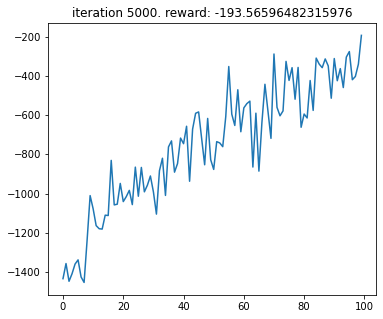

In [9]:
iteration = 0
max_iterations = 5000

# The idea of the A2C model is to use trials with few steps
# and let the model generalize from the batch derived from the multiple envoironments
num_steps = 20

# Array to save the results
test_rewards = []
all_actor_losses = []
all_critic_losses = []

# When an envoironment is done, the multiprocessing function
# return automatically as new state a new initial state
# so we need to reset the envoironments just once at the beginning
state = envs.reset()

while iteration < max_iterations:

    # We are going to backpropagate two losses (actor and critic), so we need 
    # two tapes to take trace of the computations that influence the gradients
    with tf.GradientTape() as t1, tf.GradientTape() as t2:

        # Arrays to save the results of a batch
        log_probs = []
        values    = []
        rewards   = []
        masks     = []
        entropy = 0

        for _ in range(num_steps):
            
            """
            1. Predict V and mu for the current state with the actor and critic networks
            """
            # The state must be converted to a tensor in order to be computed by the networks
            state = tf.convert_to_tensor(state) 
            
            # Obtain the mu and the value of the current state from the actor and critic networks
            value = critic(state)
            mu = actor(state)
            
            """
            2. Sample the actions from the normal distribution given mu and sigma
            """
            # To have the std of the normal distribution we need to exponentiate the log_std
            sigma = tf.math.exp(log_sigma)
            # Now we can generate a normal distribution from the mean and the std
            dist = tfp.distributions.Normal(mu, sigma)
            # We don't want to take trace of the gradients when we sample an action
            action = tf.stop_gradient(dist.sample())
            
            """
            3. Apply the actions to the envoironments and obtaine the next states, rewards and masks
            """
            next_state, reward, done, _ = envs.step(action.numpy())

            """
            4. Save the results obtained
            """
            # Obtain the log probability of the normal distribution for the actions performed
            log_prob = dist.log_prob(action)
            
            # Taking trace of the mean entropy of the normal distribution can make the the learning smoother
            entropy += np.mean(dist.entropy())

            # Save the log_probabilities, the values and the reward obtained in the arrays
            log_probs.append(log_prob)
            values.append(value)
            rewards.append(tf.expand_dims(tf.convert_to_tensor(reward), 1))
            
            # Since we don't now if in an envoironment we reached the final state, we need to
            # take trace of the final states in an array of masks in order to compute correctly the gae
            masks.append(tf.expand_dims(tf.convert_to_tensor(1 - done, dtype='float64'), 1))

            state = next_state

        """
        5. Compute the returns using the generalized advantage estimator 
        """
        # To compute the gae we need the values of the next states
        next_state = tf.convert_to_tensor(next_state)
        next_value = critic(next_state)
        returns = compute_gae(next_value, rewards, masks, values)

        """
        6. Retrieve the losses
        """
        # To make the computations faster we can vectorize all the log probabilities, values and returns
        # of the current iteration
        log_probs = tf.concat(log_probs, axis=0)
        values    = tf.concat(values, axis=0)
        # Since we used the predicted Values to compute the reurns, the gradient will follow those computations;
        # we don't want that: the returns must be simple numerical values from which we can obtain the advantage
        returns   = tf.stop_gradient(tf.concat(returns, axis=0))

        # The vectorized advantage is the difference between all the returns and all the predicted values
        advantage = returns - values
    
        # The actor loss is defined by the log probability multiplied by the advtantage. We need to take
        # only numerical value for the advtange to not mix the gradients of the actor and the critic.
        # Since everything is vectorized for the entire batch, we're gonna maximize the mean of the log probabilities
        # multiplied by the advntantages. The entropy is substracted to keep the learning more stable
        actor_loss  = - tf.reduce_mean(log_probs * tf.stop_gradient(advantage)) - 0.001 * entropy 
        
        # The critic learning can be seen as a normal regression problem: therefore in this case the loss is defined 
        # just by mean squared error of the rerunrs - values (i.e. the advtantage)
        critic_loss = tf.reduce_mean(tf.math.pow(advantage, 2))
        
        # Save the actor and critic losses to plot them later
        all_actor_losses.append(actor_loss.numpy())
        all_critic_losses.append(critic_loss.numpy())

    

    """
    7. Retrieve the gradients and apply them to all the variables
    """
    # Using the first tape, from the actor loss we can derive at the same time the gradients in respect to the parameters of the
    # actor network and to the sigma variable
    grads_actor, grad_sigma = t1.gradient(actor_loss, [actor.trainable_variables, sigma])
    # Using the second tape, from the critic loss we can derive the gradients for the critic network
    grads_critic = t2.gradient(critic_loss, critic.trainable_variables)
    
    # Now we can apply the gradientes to update all the variables
    opt_actor.apply_gradients(zip(grads_actor, actor.trainable_variables))
    opt_critic.apply_gradients(zip(grads_critic, critic.trainable_variables))
    
    # At the begining of the training sigma is quite large (log_sigma= 1, sigma=2.7), 
    # we want to diminuish it by the time to reduce slowly the exploration. 
    # Since the gradients were maximezed in respect to the actor loss, 
    # for sigma we need to take to apply the negative gradients 
    opt_sigma.apply_gradients(zip([-grad_sigma], [log_sigma]))
    
    """
    8. Test the current model in a single envoironment and save the rewards
    """
    
    iteration += 1     
    # Every each 50 iterations we test the model in one single envoironemnt (10 times) and we plot the results
    if iteration % 50 == 0:
        test_rewards.append(np.mean([test_env() for _ in range(10)]))
        plot(iteration, test_rewards)
    
    # The envoironment is considered to be solved when the model is able to reach a reward greather than -200
    # as average of 10 experiments
    if iteration > 100 and iteration % 10 == 0 and test_rewards[-1] > - 200:
        break

#### Plot and save results

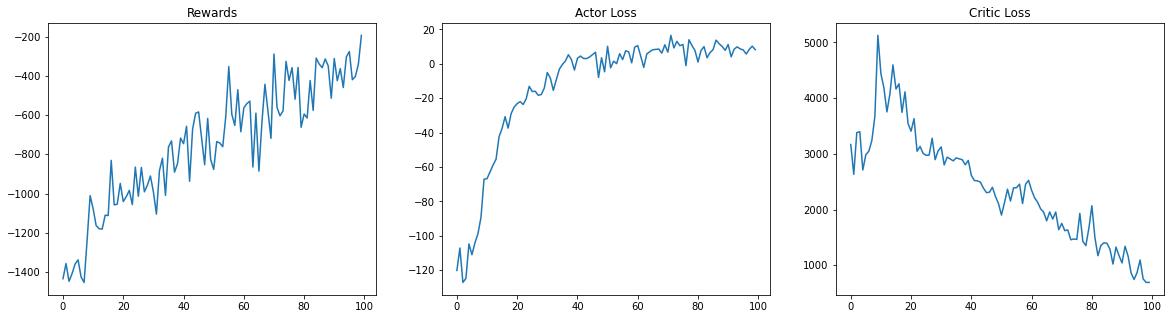

In [13]:
plt.figure(figsize=(20,5))

plt.subplot(131)
plt.title('Rewards')
plt.plot(test_rewards)

plt.subplot(132)
plt.title('Actor Loss')
plt.plot(np.mean(np.reshape(all_actor_losses, (-1, 50)), axis=1)) # take the mean of every 10 elements

plt.subplot(133)
plt.title('Critic Loss')
plt.plot(np.mean(np.reshape(all_critic_losses, (-1, 50)), axis=1)) # take the mean of every 10 elements

plt.savefig('./plots/pendulum.png')
plt.show()

To take a look at the learned behaviour run the following cell

In [11]:
for _ in range(5):
    test_env(True)
env.close()

The following cell is used to save a video of one experiment in the envoironment

In [12]:
import gym
from gym import wrappers

env_to_wrap = gym.make('Pendulum-v0')
env = wrappers.Monitor(env_to_wrap, 'PendulumVideo', force = True)

state = env.reset()
for t in range(1000):
    state = tf.convert_to_tensor(state)
    state = tf.expand_dims(state, 0)
    mu = actor(state)
    dist = tfp.distributions.Normal(mu, sigma)
    action = dist.sample()
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
        break

env.close()
env_to_wrap.close()